In [1]:
import os
import numpy as np
import pandas as pd
import torch
import random

from utils import seed_everything,data_load,

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
DATA_PATH = '../EDA/'

### Parameter Class 설정

In [2]:
class CFG:
    START_IDX = 90000000
    SEED = 42
    TEST_SIZE = 0.2
    N_EPOCHS = 5
    BATCH_SZ = 1024
    PATIENCE = 3
    VIRTUAL_BS = 128
    LR = 0.01
    ND = 8  # Width of the decision prediction layer. Bigger values gives more capacity to the model with the risk of overfitting. 
    NA = 8  # Width of the attention embedding for each mask. According tos the paper n_d=n_a is usually a good choice. 
    N_STEPS = 3 # Number of steps in the architecture (usually between 3 and 10)
    GAMMA = 1.3 # This is the coefficient for feature reusage in the masks. A value close to 1 will make mask selection least correlated between layers. 
    #Values range from 1.0 to 2.0.
    N_INDEPENDENT = 1 # Number of independent Gated Linear Units layers at each step. Usual values range from 1 to 5.
    LAMBDA = 0
    N_SHARED = 3 # Number of shared Gated Linear Units at each step Usual values range from 1 to 5
    MOMENTUM = 0.1
    CLIP = 1.0
    MASK_TYPE = 'sparsemax' #(default='sparsemax') Either "sparsemax" or "entmax" : this is the masking function to use for selecting features

### Feature_engineering, train_test_split

In [3]:
def feature_engineering(df):
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    ## 유저별 맞춘 개수를 한칸 아래로 땡기기(shift 1)
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    ## 유저별 문제 푼 개수 cumcount
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    # 유저별 푼 문제수에 따른 정확도
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    
    ## 시험지별 정답률과 맞춘 횟수
    correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
    correct_t.columns = ["test_mean", 'test_sum']
    ## 문제 유형별 정답률과 맞춘 횟수
    correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_sum']

    ## df에 시험지별 정답률과 맞춘 횟수 추가
    df = pd.merge(df, correct_t, on=['testId'], how="left")
    ## df에 문제 유형별 정답률과 맞춘 횟수 추가
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    
    return df

In [4]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
def custom_train_test_split(df, ratio=0.7, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

### Data -> train,valid,test

In [5]:
seed_everything(CFG.SEED)
cat_features = ['userID','assessmentItemID','testId','KnowledgeTag']
df = data_load(DATA_PATH)
df = feature_engineering(df)
df.fillna(0,inplace = True)
df = categorical_feature(df,cat_features)
train = df[df['answerCode']>-1]
test = df[df['answerCode']==-1]
train,valid = custom_train_test_split(train)

### 사용 Feature 설정

In [6]:
# 유저, 문제, 시험지, 태그 추가
FEATS = ['userID','assessmentItemID','testId','KnowledgeTag','Time','Timediff','Timepassed','assess_count',
         'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum','answerCode']
train_set = train[FEATS]
valid_set = valid[FEATS]
cat_idxs = [train_set.columns.get_loc(col) for col in cat_features]
cat_dims = [df[col].nunique() for col in cat_features]

In [7]:
# 카테고리 제외
FEATS = ['Time','Timediff','Timepassed','assess_count',
         'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum','answerCode']
train_set = train[FEATS]
valid_set = valid[FEATS]
# cat_idxs = [train.columns.get_loc(col) for col in cat_features]
# cat_dims = [train[col].nunique() for col in cat_features]

### TabNet 불러오기

In [7]:
model = TabNetClassifier(
    n_d = CFG.ND,
    n_a = CFG.NA,
    n_steps = CFG.N_STEPS,
    gamma = CFG.GAMMA, 
    n_independent = CFG.N_INDEPENDENT,
    n_shared = CFG.N_SHARED,
    cat_emb_dim=1,
    optimizer_params=dict(lr=CFG.LR),
    momentum=CFG.MOMENTUM,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    verbose=1,
    #scheduler_params=dict(milestones=[20, 50, 80], gamma=0.5), 
    #scheduler_fn=torch.optim.lr_scheduler.MultiStepLR,
    mask_type = CFG.MASK_TYPE,
    lambda_sparse = CFG.LAMBDA,
    clip_value = CFG.CLIP
)

/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


### 모델 학습

In [8]:
model.fit(
    X_train = train_set.drop(columns = 'answerCode').values,
    y_train = train_set['answerCode'].values,
    eval_set = [(valid_set.drop(columns = 'answerCode').values,valid_set['answerCode'].values)],
    max_epochs = CFG.N_EPOCHS, 
    patience = CFG.PATIENCE,
    batch_size = CFG.BATCH_SZ, 
    virtual_batch_size = CFG.VIRTUAL_BS,
    num_workers = 0,
    weights = 1,
    drop_last = False
)

epoch 0  | loss: 0.61505 | val_0_auc: 0.68127 |  0:02:08s
epoch 1  | loss: 0.58664 | val_0_auc: 0.70895 |  0:04:22s
epoch 2  | loss: 0.54273 | val_0_auc: 0.72205 |  0:06:34s
epoch 3  | loss: 0.52707 | val_0_auc: 0.71737 |  0:08:44s
epoch 4  | loss: 0.52056 | val_0_auc: 0.71597 |  0:10:48s
Stop training because you reached max_epochs = 5 with best_epoch = 2 and best_val_0_auc = 0.72205


/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


### 모델 저장 및 불러오기

In [9]:
# save tabnet model
saving_path_name = "./saved/tabnet_model_add_ID"
saved_filepath = model.save_model(saving_path_name)

# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

Successfully saved model at ./saved/tabnet_model_add_ID.zip


/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


### Test set Prediction

In [26]:
# MAKE PREDICTION
total_preds = model.predict(test[FEATS].drop(columns = 'answerCode').values)
preds = np.where(total_preds>=0.5,1,0)
submission = pd.read_csv('../../data/sample_submission.csv')
submission['prediction'] = preds

In [27]:
submission.to_csv('./submission/submission.add_cat.csv')

### Explain

In [14]:
explain = model.explain(valid_set.drop(columns = 'answerCode').values)

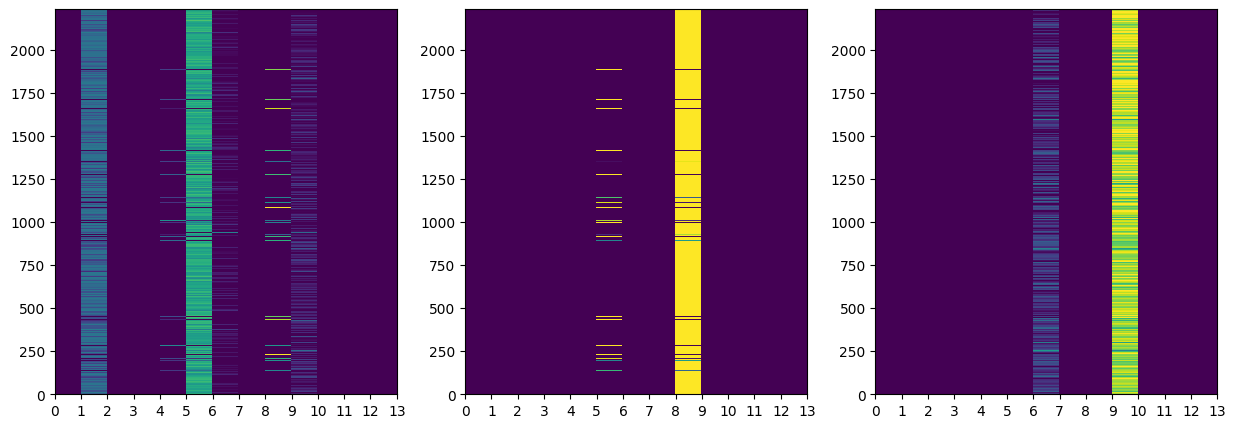

In [20]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,3,figsize = (15,5))

for i,ax in enumerate(axes):
    pcm = ax.pcolor(explain[1][i],vmin = 0, vmax = 1)
    ax.set_xticks(range(len(FEATS)))

In [29]:
temp = np.zeros_like(explain[1][0])
temp

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
explain[1][0]

/tmp/ipykernel_68867/4226347720.py:7: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(temp)


AttributeError: 'numpy.ndarray' object has no attribute 'get_array'

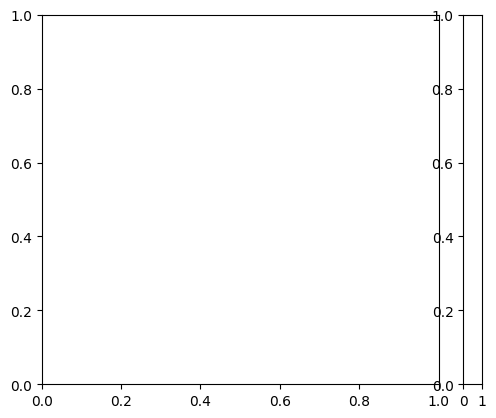

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize = (5,5))

temp = np.zeros_like(explain[1][0])
for i in range(CFG.N_STEPS):
    temp += explain[1][i]

pcm = ax.pcolor(temp,vmin = 0, vmax = 1)
ax.set_xticks(range(len(FEATS)))
plt.show()